In [1]:
import duckdb
import pandas as pd 
import numpy as np 
import seaborn as sns
import plotly.express as px
from dotenv import load_dotenv
import os
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
from pylab import rcParams
plt.style.use('fivethirtyeight')

In [2]:
# get MotherDuck token from env
load_dotenv('.env')
token = os.getenv('motherduck_token')


In [3]:
# connect to the database
con = duckdb.connect(f"md:?motherduck_token={token}")

# define your SQL query
sql_query = "SELECT * FROM stocks_clouddb.msft_data"

# execute the query and fetch the result into a DataFrame
df = con.sql("SELECT * FROM stocks_clouddb.msft_data").fetchdf().copy()

# Extract the close price column
df_close = df['close_price']


In [4]:
# display the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())

First few rows of the dataset:
             datetime  open_price  day_high   day_low  close_price  \
0 1986-03-12 21:00:00    0.055004  0.063093  0.055004     0.060396   
1 1986-03-13 21:00:00    0.060396  0.063632  0.060396     0.062553   
2 1986-03-16 21:00:00    0.062553  0.064172  0.062553     0.063632   
3 1986-03-17 21:00:00    0.063632  0.064172  0.061475     0.062014   
4 1986-03-18 21:00:00    0.062014  0.062553  0.060396     0.060936   

       volume  dividends  stock_splits  
0  1031788800        0.0           0.0  
1   308160000        0.0           0.0  
2   133171200        0.0           0.0  
3    67766400        0.0           0.0  
4    47894400        0.0           0.0  


In [5]:
# Convert datetime column to the correct format
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d')

# Set datetime column as the index of the dataframe
df.set_index('datetime', inplace=True)



## ARIMA Model
### Check for Stationarity of Time Series
Before building the ARIMA (Auto Regression Integrated Moving Average) model to predict stock price, we need to check the stationarity of a time series by using the Augmented Dickey-Fuller(ADF) unit root test. The p-value resulting from the ADF test has to be less than 0.05 or 5% for a time series to be stationary. The charts helps us in identifying the patterns and variation in the data. From the following output, it showed the p-value is greater than 0.05 or 5%, which means it is non-stationar.

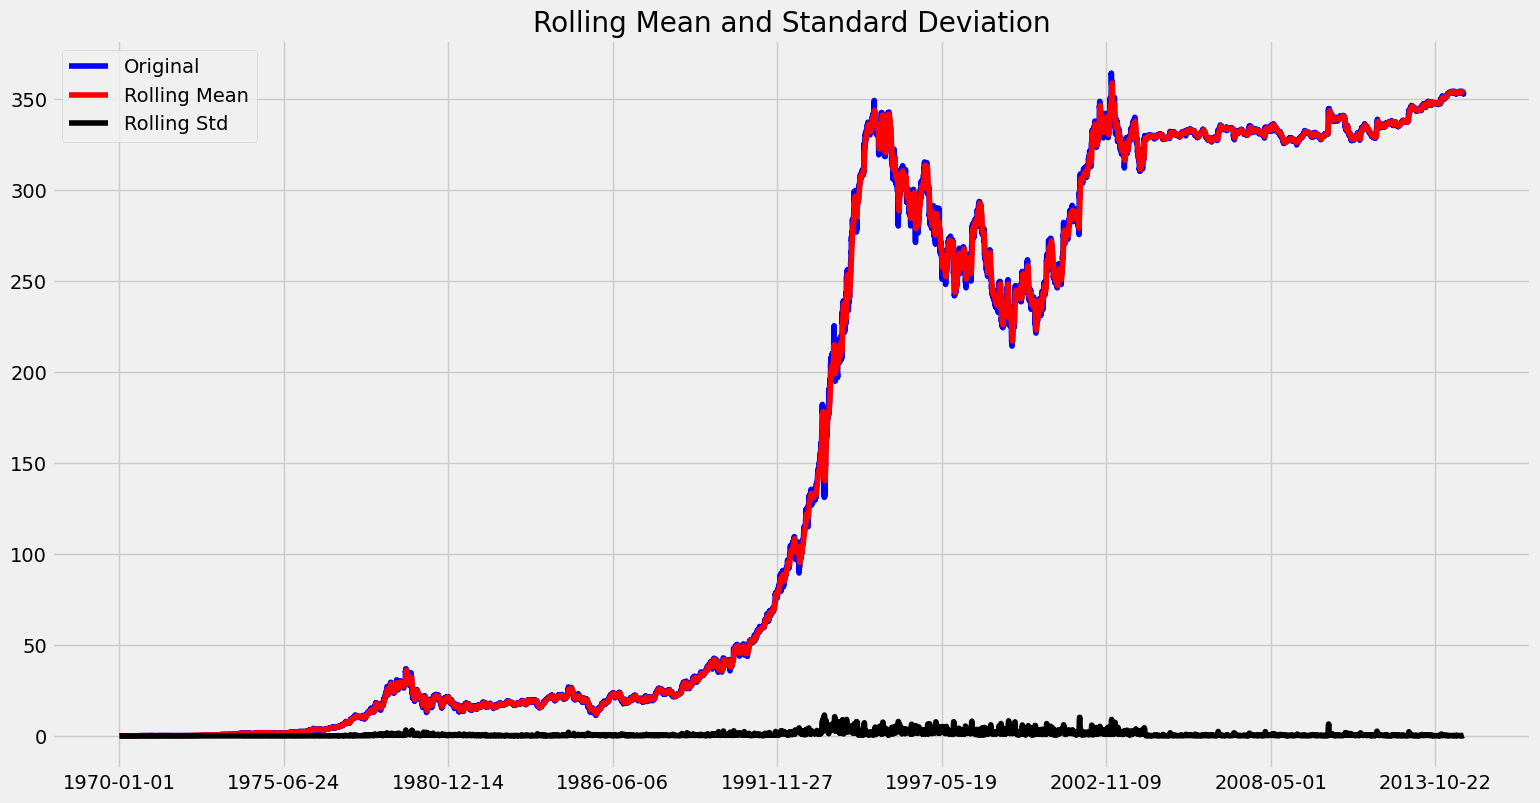

Results of Dickey fuller test
Test Statistics                   -0.103687
p-value                            0.949070
No. of lags used                  43.000000
Number of observations used    16301.000000
critical value (1%)               -3.430751
critical value (5%)               -2.861717
critical value (10%)              -2.566864
dtype: float64


In [6]:
# Define a function to test for stationarity 
def test_stationarity(timeseries):
    # determing rolling statistics 
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    # plot rolling statistics 
    fig, ax = plt.subplots(figsize=(17, 9))
    ax.plot(timeseries, color='blue',label='Original')
    ax.plot(rolmean, color='red', label='Rolling Mean')
    ax.plot(rolstd, color='black',label ='Rolling Std')
    ax.legend(loc='best')
    ax.set_title('Rolling Mean and Standard Deviation')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.show(block=False)

    print("Results of Dickey fuller test") 
    adft= adfuller(timeseries, autolag ='AIC')
    # output for dft won't define what the values are
    # hence we manually write what values does it explain using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df_close)


As it is non-stationary, we need to eliminate trend. To reduce the magnitude of the values and the growing trend in the series, we first take a log of the series. We then calculate the rolling average of the series after obtaining the log of the series. A rolling average is computed by taking data from the previous 12 months and calculating a mean consumption value at each subsequent point in the series.The moving average is used to smooth out short-term fluctuation in the data and highlight the underlying trend. It helps us identify long-term patterns and trends in the stock price. The standard deviation measures the dispersion of the data, which can guide the selection of ARIMA model parameters, such as the order of the autoregressive (AR) and moving average (MA) components. Low values suggest more stability, vice visa.  This chart help us assess trends, seasonality, and periods of high or low volatility in the data.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


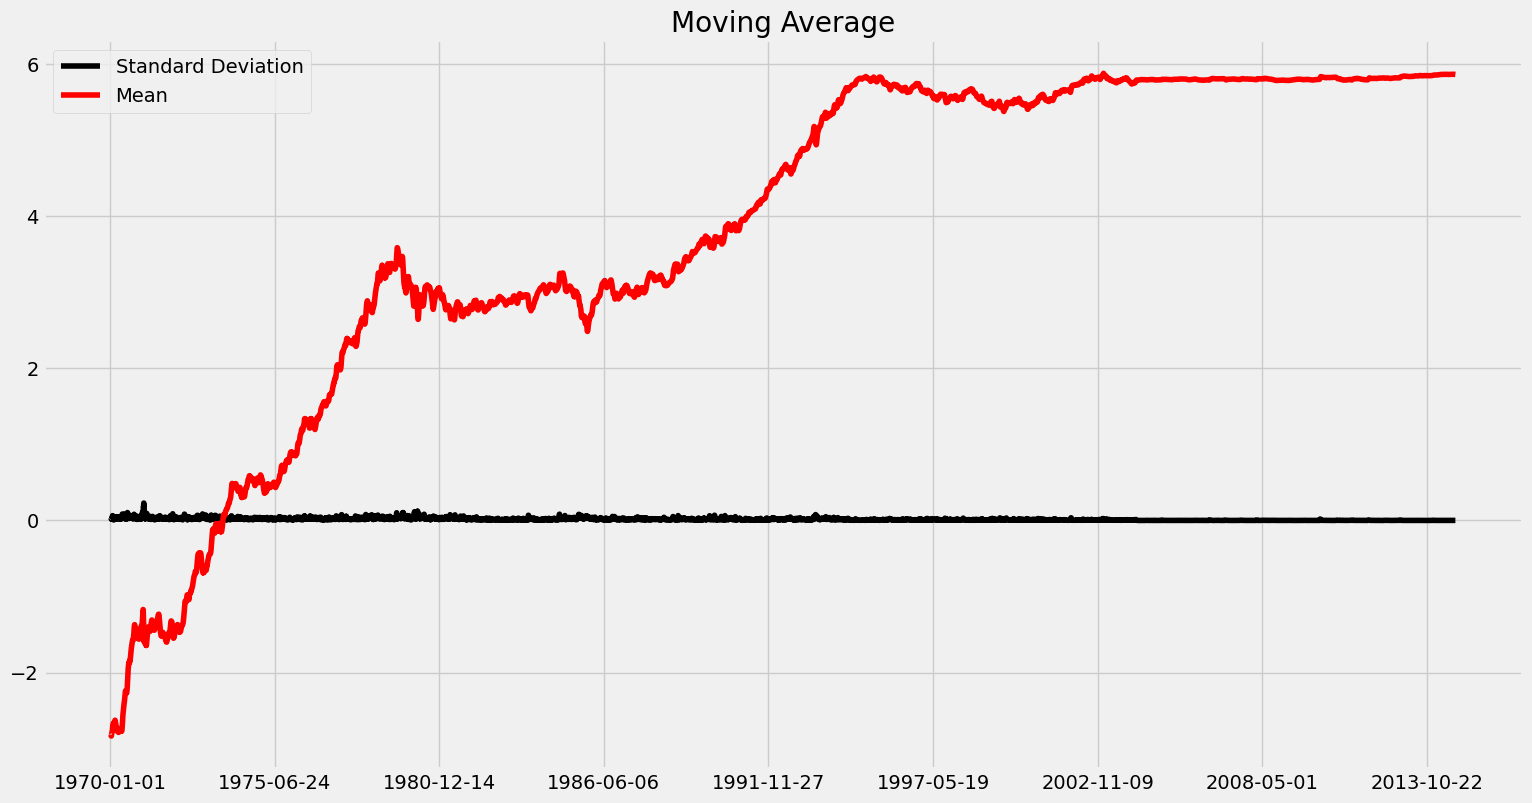

In [7]:
# if it's not stationary then eliminate trend
rcParams['figure.figsize'] = 17, 9
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.legend()
plt.show()

### Training and Testing Data

Before developing an ARIMA model, we need to split the data into training and testing dataset to evaluate how well the ARIMA model performs in forecasting unseen future data. From the chart below, we could visualize these two datasets. After training an ARIMA model using the training data, we can use the testing data to make forecasts and compare them to the actual values. This will help us evaluate the model's ability to predict future stock prices accurately.

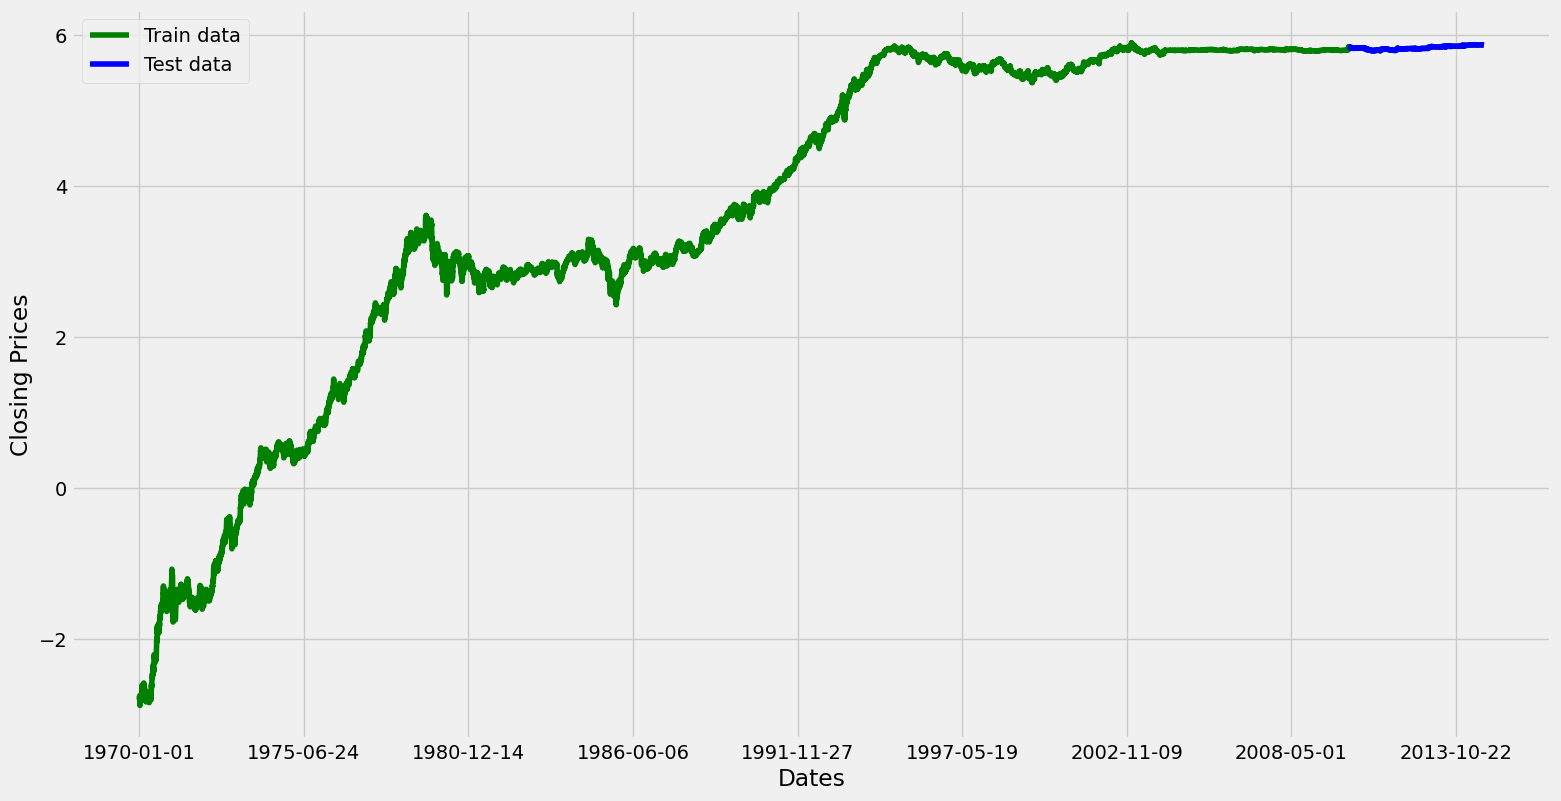

In [8]:
# split data into testing and training set and visualize it 
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(17,9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.legend()

### Auto ARIMA Model Development

We are going to use auto ARIMA automatically discover the optimal parameters for an ARIMA model. The Auto ARIMA model is a type of time series forecasting model that automatically identifies the best parameters (p, d, q) for the ARIMA model.

The ARIMA(1,1,2) model was identified as the best model. This means that it uses one past value (AR term), one level of differencing (to make the time series stationary), and two past forecast errors (MA term).

The AIC (Akaike Information Criterion) of the best model is -77959.159. AIC is a measure of the goodness of fit of the model. The lower the AIC, the better the model is at predicting the future values.

The Log Likelihood of the model is 38984.580. This is a measure of the probability that the model could have produced the observed data. The higher the log likelihood, the better.

The chart is a diagnostic tool to check the validity of the model. The left part is a QQ plot, which compares the residuals (the difference between the observed and predicted values) to a normal distribution. If the blue points closely follow the red line, it means the residuals are normally distributed, which is a good sign.

The right part is a histogram of the residuals with a Kernel Density Estimate (KDE) plot. The KDE plot is the smooth line. If the KDE plot closely follows a normal distribution (the red dotted line), it means the residuals are normally distributed, which is another good sign.

In summary, the output and the chart suggest that your model is a good fit for the data and should provide reliable forecasts of Microsoft’s stock prices.

In [9]:
import statsmodels.api as sm

In [10]:
print(sm.__version__)

0.14.0


In [11]:
! pip install -U statsmodels

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-77928.810, Time=7.94 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-77931.269, Time=6.39 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-77931.602, Time=37.89 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-77913.540, Time=3.89 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-77929.428, Time=12.96 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-77949.217, Time=12.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-77959.159, Time=16.94 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-77957.592, Time=15.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-77958.639, Time=27.56 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-77957.291, Time=19.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-77942.830, Time=16.24 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-77954.296, Time=29.43 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-77939.951, Time=6.40 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 2

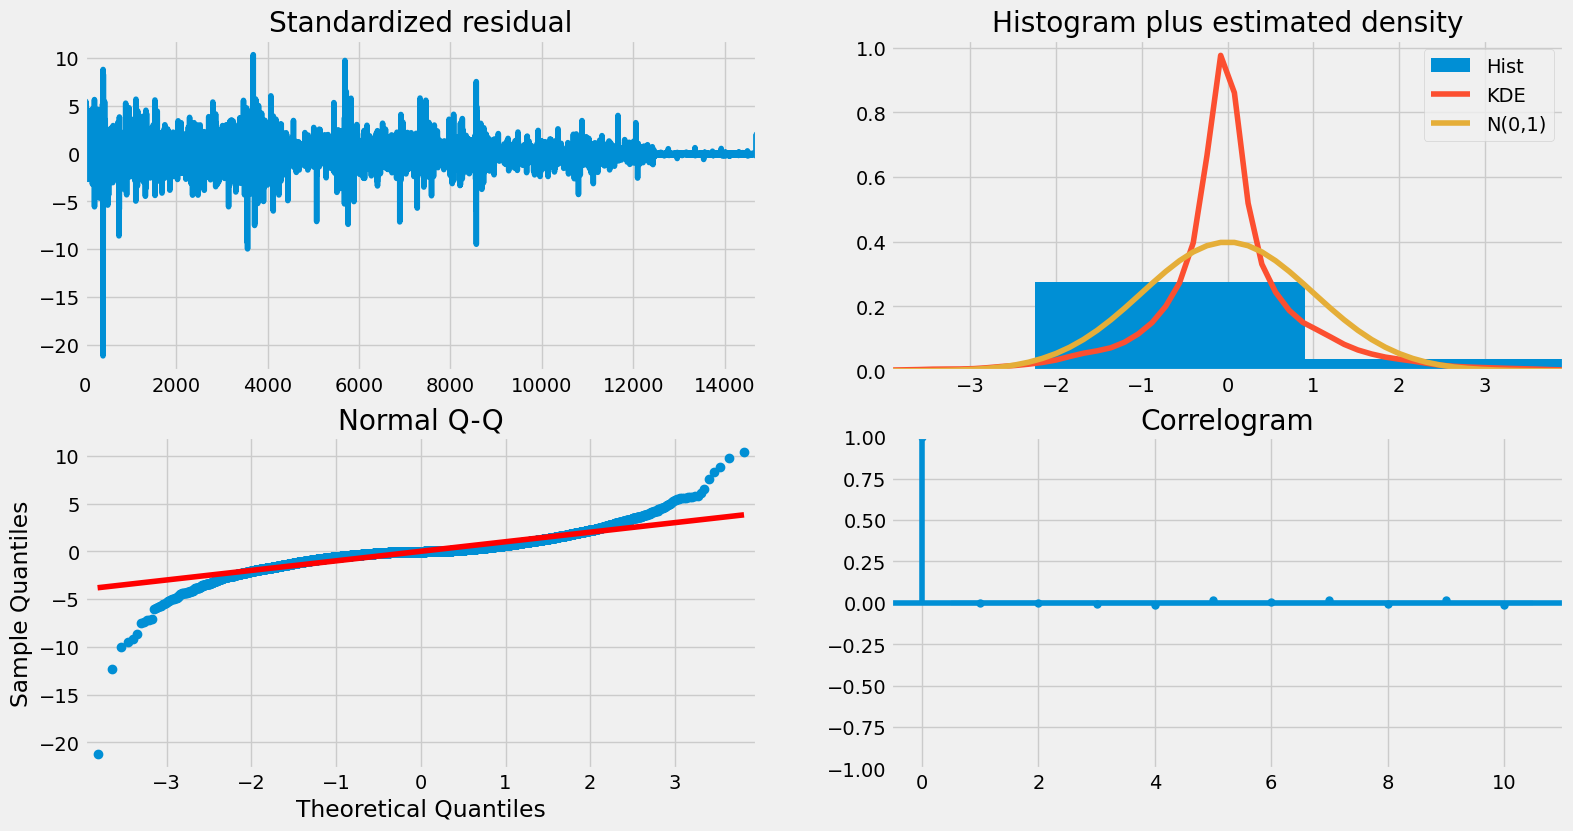

In [12]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(17,9))


plt.show()

The above Auto ARIMA model assigned the values 1,1,and 2 to p, d and q respectively to build the model.  This means it uses one autoregressive term (AR), one order of differencing (I), and two moving average terms (MA). The following is the meaning of the output： 

Coefficients: The ‘coef’ column shows the weight (i.e., importance) of each feature. For your model, the AR term (ar.L1) has a coefficient of 0.4906, the first MA term (ma.L1) has a coefficient of -0.5092, and the second MA term (ma.L2) has a coefficient of -0.0252. The sign of the coefficients indicates the direction of the relationship with the stock price.

P>|z|: This column tells us the significance of each feature weight. A lower value means the feature is more significant. In your model, all features have a p-value of 0.000, which indicates they are highly significant.

Ljung-Box Test: This test checks for any autocorrelation in the residuals of your model. The Prob(Q) value is 0.91, which is greater than 0.05, indicating that the residuals are independent and there’s no autocorrelation.

Jarque-Bera Test: This test checks whether the residuals are normally distributed. The Prob(JB) value is 0.00, which is less than 0.05, indicating that the residuals are not normally distributed.

Heteroskedasticity Test: This test checks for constant variance in the residuals (homoscedasticity). The Prob(H) value is 0.00, which is less than 0.05, indicating that the residuals do not have constant variance (heteroscedasticity).


In [13]:
# build model
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:            close_price   No. Observations:                14707
Model:                 ARIMA(1, 1, 2)   Log Likelihood               38973.976
Date:                Wed, 15 Nov 2023   AIC                         -77939.951
Time:                        00:05:58   BIC                         -77909.567
Sample:                             0   HQIC                        -77929.860
                              - 14707                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4906      0.079      6.207      0.000       0.336       0.646
ma.L1         -0.5092      0.079     -6.485      0.000      -0.663      -0.355
ma.L2         -0.0252      0.005     -5.539      0.0

Now, let's start forecasting stock prices on the test dataset with a 95% confident level. From the plot below, we can see that the predicted price is closely align with the actual price. 

From the chart, it seems like ARIMA model is doing a pretty good job of predicting the stock price, as the orange line (predicted price) closely follows the blue line (actual price). However, there are some periods where the model’s predictions deviate from the actual prices, which is where the model’s uncertainty (gray area) comes into play.

Blue Line (Actual Stock Price): This line represents the actual stock price of Microsoft (MSFT) over time. It’s based on real data from the stock market.

Orange Line (Predicted Stock Price): This line represents the predicted stock price of MSFT over time, as forecasted by your ARIMA model. It’s what your model thinks the stock price will be.

Gray Area (Confidence Interval): This shaded area represents the range within which the actual stock price is likely to fall, with a confidence of 95%. In other words, your model is 95% confident that the actual stock price will fall within this range. The wider this area, the more uncertainty there is in the prediction.

c:\Users\Admin\miniconda3_Used_this_one\envs\pred-env\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


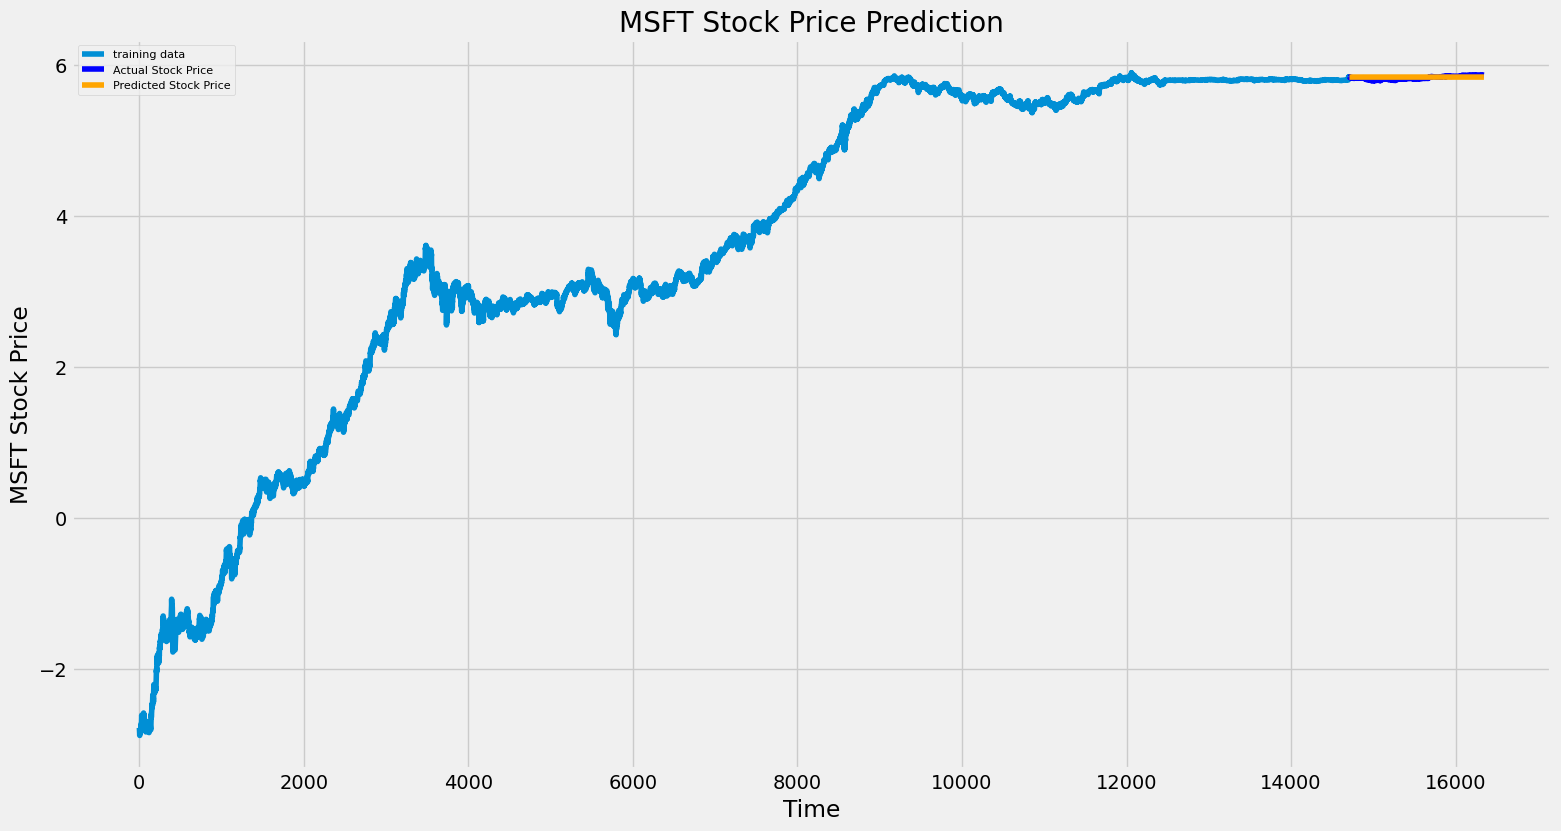

In [14]:
# forecast 

fc = fitted.forecast(steps=len(test_data), alpha=0.05) 
# make as pandas series
fc_series = pd.Series(fc, index=test_data.index)

# calculate the lower and upper bounds of the confidence interval manually
forecast_std = fitted.get_prediction(start=0, end=len(train_data) - 1).se_mean
alpha = 0.05  # 95% confidence interval
z = stats.norm.ppf(1 - alpha / 2)
lower_series = fc - z * forecast_std
upper_series = fc + z * forecast_std

lower_series = pd.Series(lower_series, index=test_data.index)
upper_series = pd.Series(upper_series, index=test_data.index)

# plot
plt.figure(figsize=(17,9), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('MSFT Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('MSFT Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


### Metrics 

Let's look at some common accuracy metrics for evaluating forecast results. The low values for MSE, MAE, RMSE, and MAPE are generally indicative of a well-performing model. They suggest that your ARIMA model is making reasonably accurate forecasts for Microsoft's stock price.

In [15]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.0005980778630609433
MAE: 0.021297357010278108
RMSE: 0.024455630498127486
MAPE: 0.0036565663707392496
